In [1]:
# Implementation of the DRAW network from ArXiv 1502.04623
# With some inspiration from Eric Jang (https://blog.evjang.com/2016/06/understanding-and-implementing.html)
# Using with py27

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
'''See: https://www.tensorflow.org/versions/r1.1/get_started/mnist/beginners'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # color maps
from sklearn.manifold import TSNE
%matplotlib inline
tf.logging.set_verbosity(tf.logging.INFO)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


/Users/adammarblestone/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# Check for GPU
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

devices = get_available_devices()

print(devices)

[u'/device:CPU:0']


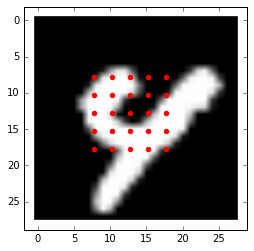

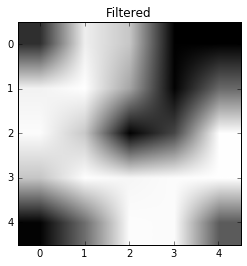

In [4]:
# We'll use these just to show, outside the TensorFlow context, what the attention / glimpse actually does

def MNIST_row_as_image(row):
    arr1 = []
    for i in range(28):
        arr2 = []
        for j in range(28):
            arr2.append(row[28*i + j])
        arr1.append(arr2)
    return np.array(arr1)

def get_filter_banks(center_coords_dec, sigma_dec, stride_dec, N): # NxN grid of filters
    A,B = 28,28 # For MNIST
    sigma_dec = np.exp(sigma_dec) # Note: sigma_decoded is the variance not the standard deviation here
    stride_dec = np.exp(stride_dec) # These start as logs
    cx = (center_coords_dec[0] + 1)*((A+1)/2)
    cy = (center_coords_dec[1] + 1)*((B+1)/2)
    center_coords = [cx, cy]
    stride = (np.max([A, B])-1) * stride_dec / (N-1)
    
    means_of_filtersx = []
    means_of_filtersy = []
    for i in range(N):
        x_mean = center_coords[0] + (i-N/2-0.5)*stride
        y_mean = center_coords[1] + (i-N/2-0.5)*stride
        means_of_filtersx.append(x_mean)
        means_of_filtersy.append(y_mean)

    filter_bank_X = [[(np.exp(-(a-means_of_filtersx[i])**2/(2*(sigma_dec))))/sum([np.exp(-(ahat-means_of_filtersx[i])**2/(2*(sigma_dec))) for ahat in range(A)]) for a in range(A)] for i in range(N)]
    filter_bank_Y = [[(np.exp(-(b-means_of_filtersy[i])**2/(2*(sigma_dec))))/sum([np.exp(-(bhat-means_of_filtersy[i])**2/(2*(sigma_dec))) for bhat in range(B)]) for b in range(B)] for i in range(N)]
    
    return filter_bank_X, filter_bank_Y, [[x,y] for x in means_of_filtersx for y in means_of_filtersy]

def filter_image_example(image, filter_bank_X, filter_bank_Y):
    return np.matmul(np.matmul(filter_bank_Y, image), np.transpose(filter_bank_X))

image_example = MNIST_row_as_image(mnist.train.images[32171][:])
plt.figure()
plt.imshow(image_example, cmap = cm.Greys_r)
filter_bank_X, filter_bank_Y, means = get_filter_banks(center_coords_dec = [0, 0], sigma_dec = -1, stride_dec = -1, N = 5)
filtered = filter_image_example(image_example, filter_bank_X, filter_bank_Y)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'r')
plt.show()
plt.figure()
plt.title("Filtered")
f = plt.imshow(filtered, cmap = cm.Greys_r)

In [5]:
def tf_get_filter_banks(center_coords_dec, sigma_dec, stride_dec, N): # NxN grid of filters
    A,B = 28,28 # For MNIST
    sigma_dec = tf.exp(sigma_dec) # Note: sigma_decoded is the variance not the standard deviation here
    stride_dec = tf.exp(stride_dec) # These start as logs
    cx = (center_coords_dec[0] + 1)*((A+1)/2)
    cy = (center_coords_dec[1] + 1)*((B+1)/2)
    center_coords = [cx, cy]
    stride = (28-1) * stride_dec / (N-1)
    
    means_of_filtersx = []
    means_of_filtersy = []
    normx = []
    normy = []
    epsilon = 0.00000001
    for i in range(N):
        x_mean = center_coords[0] + (i-N/2-0.5)*stride
        y_mean = center_coords[1] + (i-N/2-0.5)*stride
        means_of_filtersx.append(x_mean)
        means_of_filtersy.append(y_mean)
        normx.append(tf.maximum(tf.reduce_sum([tf.exp(-(ahat-means_of_filtersx[i])**2/(2*(sigma_dec))) for ahat in range(A)]), epsilon))
        normy.append(tf.maximum(tf.reduce_sum([tf.exp(-(bhat-means_of_filtersy[i])**2/(2*(sigma_dec))) for bhat in range(B)]), epsilon))
        
    filter_bank_X = [[(tf.exp(-(a-means_of_filtersx[i])**2/(2*(sigma_dec))))/normx[i] for a in range(A)] for i in range(N)]
    filter_bank_Y = [[(tf.exp(-(b-means_of_filtersy[i])**2/(2*(sigma_dec))))/normy[i] for b in range(B)] for i in range(N)]
    
    return filter_bank_X, filter_bank_Y

In [6]:
# With some inspiration from Eric Jang: https://blog.evjang.com/2016/06/understanding-and-implementing.html
num_time_steps = 10
num_units_enc = 25
num_units_dec = 25
num_latents = 10
N = 5
A = 28
B = 28

batch_size = 1

DO_SHARE = False

# Recorded variables

canvas = [None] * num_time_steps
center_coords_decoded = [None] * num_time_steps
sigma_decoded = [None] * num_time_steps
stride_decoded = [None] * num_time_steps
gamma_decoded = [None] * num_time_steps
lms = [None] * num_time_steps
lss = [None] * num_time_steps

# Setting up the computational graph

x = tf.placeholder(shape=[batch_size, A*B],dtype=tf.float32, name = 'x')
canvas_previous = tf.zeros(shape=[batch_size, A*B])

encoder_cell = tf.contrib.rnn.LSTMBlockCell(num_units = num_units_enc)
encoder_state_previous = encoder_cell.zero_state(batch_size, tf.float32)
def encode_step(input_data, network_state):
    with tf.variable_scope("encoder",reuse=DO_SHARE):
        return encoder_cell(inputs = input_data, state = network_state) # This does one cycle of the RNN
        # This uses the __call__ method

decoder_cell = tf.contrib.rnn.LSTMBlockCell(num_units = num_units_dec)
decoder_state_previous = decoder_cell.zero_state(batch_size, tf.float32)
def decode_step(latents, network_state):
    with tf.variable_scope("decoder",reuse=DO_SHARE):
        return decoder_cell(inputs = latents, state = network_state) # This does one cycle of the RNN
        # This uses the __call__ method

for t in range(num_time_steps): # Replace with tf.while_loop
    print ("Setting up graph for time-step %i" %t)
    
    xhat = x-tf.sigmoid(canvas_previous)
    
    # Do the read operation
    with tf.variable_scope("read_operation",reuse=DO_SHARE):
        read_params = tf.gather(tf.contrib.layers.fully_connected(inputs = decoder_state_previous.h, num_outputs = 5, activation_fn = None), 0)

    center_coords_decoded[t] = [read_params[0],read_params[1]]
    sigma_decoded[t], stride_decoded[t], gamma_decoded[t] = read_params[2]-0.5, read_params[3]-0.5, read_params[4]
    # Added the minus 0.5 here to try to initialize it to a smaller attention spot
    filter_bank_X, filter_bank_Y = tf_get_filter_banks(center_coords_decoded[t], sigma_decoded[t], stride_decoded[t], N)
   
    read_result = [tf.exp(gamma_decoded[t])*tf.matmul(tf.matmul(filter_bank_Y, tf.gather(tf.reshape(x, [1,A,B]),0)), tf.transpose(filter_bank_X)), tf.exp(gamma_decoded[t])*tf.matmul(tf.matmul(filter_bank_Y, tf.gather(tf.reshape(xhat, [1,A,B]),0)), tf.transpose(filter_bank_X))] 
    
    # Update the encoder state
    encoder_state = encode_step(input_data = tf.concat([tf.reshape(read_result, [1,N*N + N*N]), tf.reshape(decoder_state_previous.h, [1,num_units_dec])], axis=-1), network_state = encoder_state_previous)
    # Note: encoder_state is the output of the LSTMCell's call method -- first output, then a LSTM state tuple
    
    # Sample the latents
    with tf.variable_scope("latents",reuse=DO_SHARE):
        latent_means = tf.contrib.layers.fully_connected(encoder_state[0], num_latents, activation_fn = None)
        latent_stds = tf.exp(tf.contrib.layers.fully_connected(encoder_state[0], num_latents, activation_fn = None))
    
    samples_without_mean = tf.random_normal([num_latents], mean=0, stddev=1, dtype=tf.float32)  
    sampled_latents = latent_means + (latent_stds * samples_without_mean)
    
    lms[t] = latent_means
    lss[t] = latent_stds
    
    # Update the decoder state
    decoder_state = decode_step(latents = sampled_latents, network_state = decoder_state_previous)
    
    # Write
    with tf.variable_scope("write_operation",reuse=DO_SHARE):
        writing_instruction =  tf.reshape(tf.contrib.layers.fully_connected(decoder_state[0], N*N, activation_fn = None), [N,N])
    
    writing_value = tf.exp(-1*gamma_decoded[t])*tf.matmul(tf.matmul(tf.transpose(filter_bank_Y), writing_instruction), filter_bank_X)
    canvas[t] =  canvas_previous + tf.reshape(writing_value, [1,A*B])
    
    # Cycle
    encoder_state_previous = encoder_state[1]
    decoder_state_previous = decoder_state[1]
    canvas_previous = canvas[t]
    
    # To turn this on after the first cycle
    DO_SHARE = True

canvas = tf.sigmoid(canvas)
    
# Setting up loss function
print("Setting up loss function...")
epsilon = 0.00000001 # A trick like this was used by Eric Jang for numerical stability, although there with cross-entropy loss -- here it avoids Inf in the log as well
loss_reconstruction = tf.reduce_mean(tf.squared_difference(canvas[num_time_steps-1],x)) # RMS reconstruction error in the pixel space
loss_latent = tf.reduce_sum([0.5 * tf.reduce_sum(tf.square(lms[t]) + tf.square(lss[t]) - tf.log(tf.square(lms)+epsilon) - 1)/batch_size for t in range(num_time_steps)])
relative_weight = 0.00001 # Between the reconstruction versus latent KL loss
loss = loss_reconstruction + relative_weight * loss_latent # this includes a manual scaling parameter

Setting up graph for time-step 0
Setting up graph for time-step 1
Setting up graph for time-step 2
Setting up graph for time-step 3
Setting up graph for time-step 4
Setting up graph for time-step 5
Setting up graph for time-step 6
Setting up graph for time-step 7
Setting up graph for time-step 8
Setting up graph for time-step 9
Setting up loss function...


In [7]:
# Setting up the optimizer (we'll have to move this above)
print("Setting up optimizer...")
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5)
print("Setting up minimization...")
print("\tComputing gradients...")
grads=optimizer.compute_gradients(loss) 
# Just doing this with respect to loss_reconstruction only, instead of loss
print("\tClipping gradients...")
for i,(g,v) in enumerate(grads):
    if g is not None:
        grads[i]=(tf.clip_by_norm(g,5),v) # Clip gradients, per Eric Jang
print("\tApplying gradients...")
train_op=optimizer.apply_gradients(grads)

Setting up optimizer...
Setting up minimization...
	Computing gradients...
	Clipping gradients...
	Applying gradients...


In [8]:
# Sanity check on variable shapes
print("All variables...")
for v in tf.all_variables():
    print("\t%s : %s" % (v.name,v.get_shape()))

All variables...
	read_operation/fully_connected/weights:0 : (25, 5)
	read_operation/fully_connected/biases:0 : (5,)
	encoder/lstm_cell/kernel:0 : (100, 100)
	encoder/lstm_cell/bias:0 : (100,)
	latents/fully_connected/weights:0 : (25, 10)
	latents/fully_connected/biases:0 : (10,)
	latents/fully_connected_1/weights:0 : (25, 10)
	latents/fully_connected_1/biases:0 : (10,)
	decoder/lstm_cell/kernel:0 : (35, 100)
	decoder/lstm_cell/bias:0 : (100,)
	write_operation/fully_connected/weights:0 : (25, 25)
	write_operation/fully_connected/biases:0 : (25,)
	beta1_power:0 : ()
	beta2_power:0 : ()
	read_operation/fully_connected/weights/Adam:0 : (25, 5)
	read_operation/fully_connected/weights/Adam_1:0 : (25, 5)
	read_operation/fully_connected/biases/Adam:0 : (5,)
	read_operation/fully_connected/biases/Adam_1:0 : (5,)
	encoder/lstm_cell/kernel/Adam:0 : (100, 100)
	encoder/lstm_cell/kernel/Adam_1:0 : (100, 100)
	encoder/lstm_cell/bias/Adam:0 : (100,)
	encoder/lstm_cell/bias/Adam_1:0 : (100,)
	latents

In [9]:
# Example run
img = mnist.train.images[32171][:]
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.initialize_all_variables())
print("Running...")
l, cv, lmsout, lssout, ccd, sig, stri = sess.run([loss, canvas, lms, lss, center_coords_decoded, sigma_decoded, stride_decoded], feed_dict = {x:[img]})
print(ccd, sig, stri)

Running...
([[0.0, 0.0], [-0.042083893, -0.11799002], [-0.065524206, 0.074562274], [0.080039635, 0.079176784], [-0.020566009, 0.094124593], [-0.17490588, -0.0078418422], [-0.18327323, 0.0034360718], [-0.19002509, -0.06665273], [-0.067274675, 0.057932638], [-0.20518936, -0.0013912073]], [-0.5, -0.42115375, -0.60832298, -0.52258158, -0.64323097, -0.69083834, -0.61862385, -0.57857352, -0.62910903, -0.5555141], [-0.5, -0.43773907, -0.4284656, -0.33894557, -0.2577886, -0.29616877, -0.15347764, -0.095552653, -0.23448038, -0.17790297])


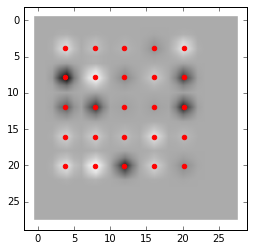

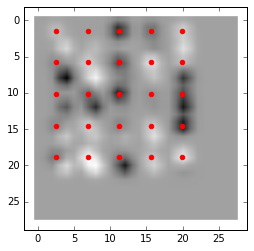

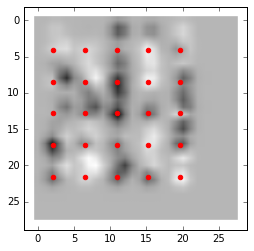

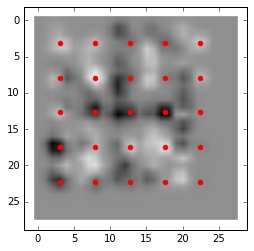

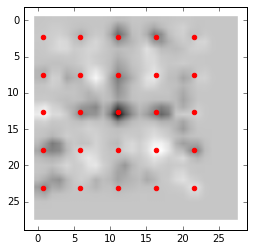

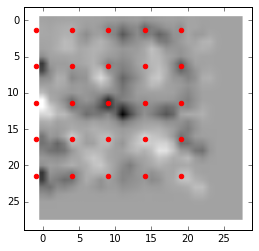

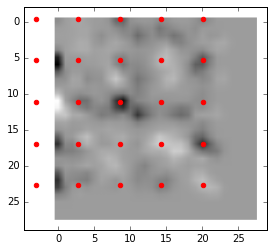

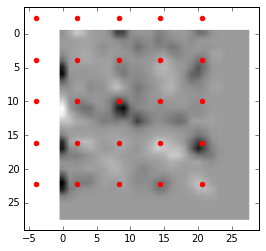

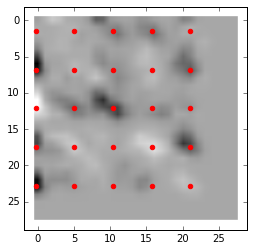

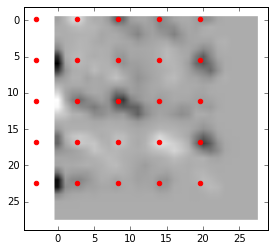

In [10]:
for t in range(len(cv)):
    c = cv[t]
    c_img = MNIST_row_as_image(c[0].tolist())
    plt.figure()
    plt.imshow(c_img, cmap = cm.Greys_r)
    filter_bank_X, filter_bank_Y, means = get_filter_banks(center_coords_dec = ccd[t], sigma_dec = sig[t], stride_dec = stri[t], N = 5)
    scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'r')
    plt.show()

In [11]:
# Real training
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.initialize_all_variables())

print("Training...")
losses_log = []
latent_losses_log = []

for i in range(5000):
    img = mnist.train.images[i][:]
    l, t_op, ll = sess.run([loss, train_op, loss_latent], feed_dict = {x:[img]})
    losses_log.append(l)
    latent_losses_log.append(ll)
    if i % 100 == 0:
        print("Finished %i, loss %f" % (i,l))

Training...
Finished 0, loss 0.254078
Finished 100, loss 0.055155
Finished 200, loss 0.061412
Finished 300, loss 0.082424
Finished 400, loss 0.077582
Finished 500, loss 0.027767
Finished 600, loss 0.062055
Finished 700, loss 0.057654
Finished 800, loss 0.075877
Finished 900, loss 0.077964
Finished 1000, loss 0.063945
Finished 1100, loss 0.070433
Finished 1200, loss 0.094321
Finished 1300, loss 0.058197
Finished 1400, loss 0.101147
Finished 1500, loss 0.047901
Finished 1600, loss 0.047103
Finished 1700, loss 0.113564
Finished 1800, loss 0.068333
Finished 1900, loss 0.044425
Finished 2000, loss 0.050146
Finished 2100, loss 0.057122
Finished 2200, loss 0.049641
Finished 2300, loss 0.076162
Finished 2400, loss 0.049684
Finished 2500, loss 0.071602
Finished 2600, loss 0.067865
Finished 2700, loss 0.070915
Finished 2800, loss 0.067514
Finished 2900, loss 0.070874
Finished 3000, loss 0.077788
Finished 3100, loss 0.050216
Finished 3200, loss 0.071773
Finished 3300, loss 0.060994
Finished 3400,

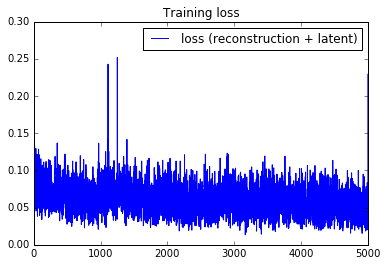

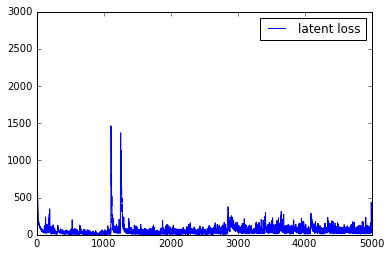

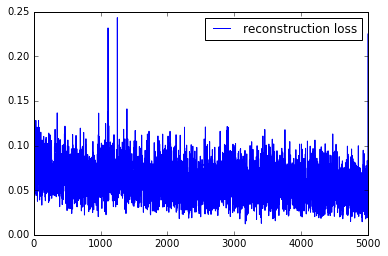

In [12]:
plt.figure()
plt.title("Training loss")
plt.plot(losses_log, label = "loss (reconstruction + latent)")
plt.legend()
plt.figure()
plt.plot(latent_losses_log, label = "latent loss")
plt.legend()
plt.show()
plt.figure()
plt.plot([losses_log[k] - relative_weight*latent_losses_log[k] for k in range(len(losses_log))], label = "reconstruction loss")
plt.legend()
plt.show()

Correct image:
Running...
Drawing steps...


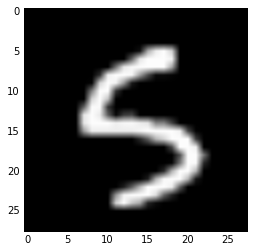

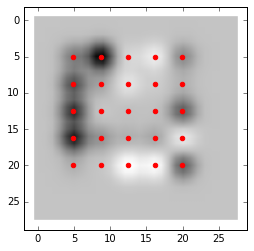

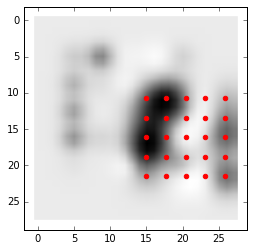

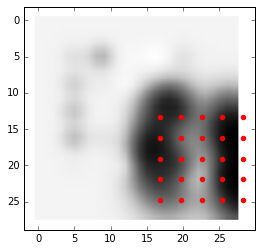

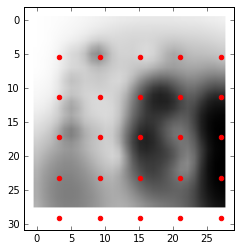

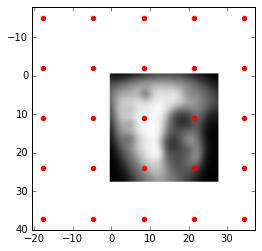

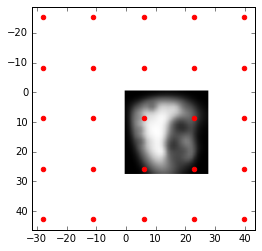

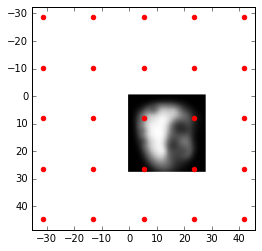

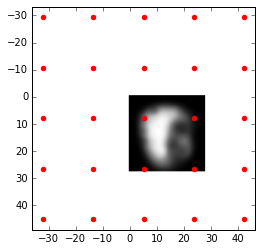

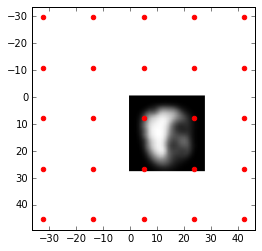

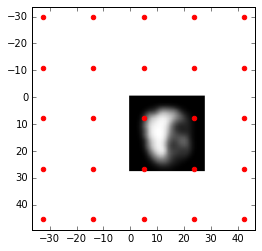

In [13]:
# Second example run, after a tiny bit of training
print("Correct image:")
img = mnist.train.images[10000][:]
plt.figure()
plt.imshow(MNIST_row_as_image(img), cmap = cm.Greys_r)
print("Running...")
l, cv, lmsout, lssout, ccd, sig, stri = sess.run([loss, canvas, lms, lss, center_coords_decoded, sigma_decoded, stride_decoded], feed_dict = {x:[img]})
print("Drawing steps...")
for t in range(len(cv)):
    c = cv[t]
    c_img = MNIST_row_as_image(c[0].tolist())
    plt.figure()
    plt.imshow(c_img, cmap = cm.Greys_r)
    filter_bank_X, filter_bank_Y, means = get_filter_banks(center_coords_dec = ccd[t], sigma_dec = sig[t], stride_dec = stri[t], N = 5)
    scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'r')
    plt.show()